<a href="https://www.kaggle.com/code/pietrobrugnolo11/loveda-grouped-segmentation-pytorch?scriptVersionId=155873151" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
pip install segmentation_models_pytorch

  Obtaining dependency information for segmentation_models_pytorch from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
  Obtaining dependency information for timm==0.9.2 from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 5.2 MB/s eta 0:00:00
  Obtaining dependency information for munch from https://files.pythonhosted.org/packages/56/b3/7c69b37f03260a061883bec0e7b05be7117c1b1c85f5212c72c8c2bc3c8c/munch-4.0.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import os
import sys
import gc
import argparse
import torch.optim as optim
import numpy as np
import torch.nn as nn
import torch.backends.cudnn as cudnn
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms as T
from torch.utils.data import Dataset
from PIL import Image 
from torch.utils.data import DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50
import segmentation_models_pytorch as smp 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device, "\n")

Using device: cuda 



In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.image_filenames = []  # List to store image file names
        self.mask_filenames = []  # List to store mask file names

        # Load image and mask file names
        self.images_dir = os.path.join(self.data_path, 'images_png')
        self.masks_dir = os.path.join(self.data_path, 'masks_png')
        self.image_filenames = sorted(os.listdir(self.images_dir))
        self.mask_filenames = sorted(os.listdir(self.masks_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_filenames[idx])
        # Load image and mask
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert('L')
        if self.transform is not None:
            state = torch.get_rng_state()
            image = self.transform(image)
            torch.set_rng_state(state)
            mask = self.transform(mask)
            
        imageT = T.ToTensor()
        maskT = T.PILToTensor()

        #image = np.array(image)
        #mask = np.array(mask)
        #image = np.transpose(image, (1, 2, 0)).astype(np.float32)
        #return (torch.from_numpy(image), torch.from_numpy(mask))
        return imageT(image), maskT(mask)

In [4]:
def dice_coef(y_pred, y_true, epsilon=1e-7):
    dice = []
    
    # compute for each class 
    classes = int(np.max(np.unique(y_true.detach().cpu().numpy())))
    for num_class in range(1, classes):
        target = (y_true == num_class)
        pred = (y_pred == num_class)
        
        intersect = (target * pred).sum()
        base = (target).sum() + (pred).sum()
        del(target); del(pred)
        
        score = (2 * intersect + epsilon) / (base + epsilon)
        dice.append(score)
        del(intersect); del(base)
    
    return (sum(dice) / len(dice)).item()

In [5]:
# UNET

class conv_block(nn.Module):

    def __init__(self, ch_in, ch_out, norm_layer=None):
        super(conv_block, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            #nn.BatchNorm2d(ch_out),
            norm_layer(num_features=ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            #nn.BatchNorm2d(ch_out),
            norm_layer(num_features=ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class up_conv(nn.Module):
    def __init__(self, ch_in, ch_out, norm_layer=None):
        super(up_conv, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            norm_layer(num_features=ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class U_Net(nn.Module):
    def __init__(self, img_ch=3, output_ch=1, norm_layer=None):
        super(U_Net, self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(ch_in=img_ch, ch_out=64, norm_layer=norm_layer)
        self.Conv2 = conv_block(ch_in=64, ch_out=128, norm_layer=norm_layer)
        self.Conv3 = conv_block(ch_in=128, ch_out=256, norm_layer=norm_layer)
        self.Conv4 = conv_block(ch_in=256, ch_out=512, norm_layer=norm_layer)
        self.Conv5 = conv_block(ch_in=512, ch_out=1024, norm_layer=norm_layer)

        self.Up5 = up_conv(ch_in=1024, ch_out=512, norm_layer=norm_layer)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512, norm_layer=norm_layer)

        self.Up4 = up_conv(ch_in=512, ch_out=256, norm_layer=norm_layer)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256, norm_layer=norm_layer)

        self.Up3 = up_conv(ch_in=256, ch_out=128, norm_layer=norm_layer)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128, norm_layer=norm_layer)

        self.Up2 = up_conv(ch_in=128, ch_out=64, norm_layer=norm_layer)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64, norm_layer=norm_layer)

        self.Conv_1x1 = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # encoding path
        x1 = self.Conv1(x)
        # print("U_Net forward:", type(x))
        # print("U_Net forward:", x.shape)
        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)  # self.Conv4 = conv_block(ch_in=256,ch_out=512)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)  # self.Conv5 = conv_block(ch_in=512,ch_out=1024)
        # print("U_Net forward:", "encoding", type(x5))
        # print("U_Net forward:", "encoding", x5.shape)

        # decoding + concat path
        d5 = self.Up5(x5)  # self.Up5 = up_conv(ch_in=1024,ch_out=512)
        d5 = torch.cat((x4, d5), dim=1)

        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        # print("U_Net forward:", "dencoding", type(d1))
        # print("U_Net forward:", "dencoding shape", d1.shape)
        return d1

In [6]:
# define parmeters and folders
class Opt():
    def __init__(self):
        self.learning_rate = 0.001
        self.print_freq = 75
        self.name_net = 'unet'  # pspnet, deeplab
        self.batch_size = 2
        self.num_workers = 2
        self.epochs = 4 
        self.num_classes = 10
        # Folders
        self.project_folder = '/kaggle/working/'
        self.train_data_folder = '/kaggle/input/loveda-grouped/LoveDA_grouped/Train/Train'
        self.val_data_folder = '/kaggle/input/loveda-grouped/LoveDA_grouped/Val/Val'
        self.results_folder = os.path.join(self.project_folder, 'results')
        if not os.path.isdir(self.results_folder):
            os.makedirs(self.results_folder)
            
opt = Opt()

In [7]:
def set_model(opt):
    if opt.name_net == 'unet':
        model = U_Net(output_ch = opt.num_classes)
        
    if opt.name_net == 'pspnet':
        model = smp.PSPNet('resnet34', in_channels=3, classes = opt.num_classes)
        
    if opt.name_net == 'deeplab':
        model = deeplabv3_resnet50(num_classes = opt.num_classes)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=opt.learning_rate)
    # scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
        cudnn.benchmark = True

    return model, criterion, optimizer

In [8]:
def save_model(model, optimizer, opt, epoch, save_file):
    print('==> Saving...')
    state = {
        'opt': opt,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
    }
    torch.save(state, save_file)
    del state

In [9]:
def set_loader(opt):

    # normalize = transforms.Normalize(mean=opt.mean, std=opt.std)

    data_transforms = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomRotation(15),
        T.Resize((128, 256)),
    ])

    train_dataset = SegmentationDataset(opt.train_data_folder, transform=data_transforms)
    train_loader = DataLoader(train_dataset, batch_size=opt.batch_size, shuffle=True, num_workers=opt.num_workers)
    val_dataset = SegmentationDataset(opt.val_data_folder)
    val_loader = DataLoader(val_dataset, batch_size=opt.batch_size, shuffle=False, num_workers=opt.num_workers)

    return train_loader, val_loader

In [10]:
def test(model, test_loader, criterion, opt):
    model.eval()
    val_loss = 0
    val_dice = 0
    total_num = 0
    with torch.no_grad():
        for image, mask in test_loader:
            if torch.cuda.is_available():
                image = image.cuda(non_blocking=True)
                mask = mask.cuda(non_blocking=True)
                
            if opt.name_net == 'deeplab':
                output = model(image)['out'] #with deeplab from torch
            else:
                output = model(image)
                
            mask = torch.squeeze(mask, dim = 1)
            loss = criterion(output, mask.long()) # mask.long() if using cross entropy
            total_num += mask.shape[0]
            val_loss += loss.item() * mask.shape[0]
            dice = dice_coef(output.argmax(dim=1), mask)
            val_dice += dice
    
    val_loss = val_loss / total_num      
    val_dice = val_dice / len(test_loader)
    print("validation loss", val_loss)
    print("validation DICE coefficient", val_dice) 
    
    return val_loss, val_dice

In [11]:
def train(model, train_loader, test_loader, criterion, optimizer, epoch, opt):
    model.train()
    total_loss, total_num = 0.0, 0
    idx = 0
    # for image, mask in train_loader:
    for image, mask in train_loader:
        optimizer.zero_grad()
        # print(torch.unique(mask)) # Must be integers
        if torch.cuda.is_available():
            image = image.cuda(non_blocking=True)
            mask = mask.cuda(non_blocking=True)

        # forward + backward + optimize
        if opt.name_net == 'deeplab':
            output = model(image)['out'] #with deeplab from torch
        else:
            output = model(image)
        
        mask = torch.squeeze(mask, dim = 1)
        # print('mask shape', mask.shape)
        # print('output shape', output.shape)
        loss = criterion(output, mask.long()) # mask.long() if using cross entropy
        loss.backward()
        optimizer.step()

        total_num += mask.shape[0]
        total_loss += loss.item() * mask.shape[0]

        if (idx + 1) % opt.print_freq == 0:
            print('Train Epoch: [{}/{}], lr: {:.6f}, Loss: {}'.format(epoch, opt.epochs,
                                                                    optimizer.param_groups[0]['lr'],
                                                                    total_loss / total_num))

            sys.stdout.flush()
        idx += 1

        gc.collect()
        torch.cuda.empty_cache()
    val_loss, val_dice = test(model, test_loader, criterion, opt)
    print("train() function - epoch total_loss", total_loss / total_num)
    train_loss = total_loss / total_num
    return train_loss, val_loss, val_dice 

In [12]:
torch.cuda.empty_cache()

# build data loader
train_loader, test_loader = set_loader(opt)
print('train e test data loader created...')

# define model
model, criterion, optimizer = set_model(opt)
save_file_1 = os.path.join(opt.results_folder, (str(opt.name_net) + '_best.pth'))

# TRAINING
print("Training...")

# training routine
best_val_dice = 0
train_loss_values, val_loss_values, val_dices = [], [], []

for epoch in range(1, opt.epochs + 1):

    train_loss, val_loss, val_dice = train(model, train_loader, test_loader, criterion, optimizer, epoch, opt)
    train_loss_values.append(train_loss)
    val_loss_values.append(val_loss)
    val_dices.append(val_dice)

    # save best model
    if val_dice > best_val_dice:
        print("saving/updating current best model at epoch=" + str(epoch))
        save_model(model, optimizer, opt, epoch, save_file_1)
        best_val_dice = val_dice

    # save loss values and plot
    tloss_df = pd.DataFrame(train_loss_values)
    vloss_df = pd.DataFrame(val_loss_values)
    dice_df = pd.DataFrame(val_dices)
    tloss_df.to_csv(opt.results_folder +'/' + (str(opt.name_net) + '_train_loss.csv'))
    vloss_df.to_csv(opt.results_folder +'/' + (str(opt.name_net) + '_val_loss.csv'))
    dice_df.to_csv(opt.results_folder +'/' + (str(opt.name_net) + '_val_dice.csv'))

    plt.figure(figsize=(15, 10))
    plt.plot(train_loss_values, label = 'train loss')
    plt.ylabel('train loss value')
    plt.xlabel('epochs')
    plt.savefig(opt.results_folder +'/' + str(opt.name_net) + ' _train_loss.png')
    plt.close()

    plt.figure(figsize=(15, 10))
    plt.plot(val_loss_values, label = 'validation loss')
    plt.ylabel('validation loss value')
    plt.xlabel('epochs')
    plt.savefig(opt.results_folder +'/' + str(opt.name_net) + ' _val_loss.png')
    plt.close()

    plt.figure(figsize=(15, 10))
    plt.plot(val_dices)
    plt.ylabel('dice value')
    plt.xlabel('epochs')
    plt.savefig(opt.results_folder +'/' + str(opt.name_net) + ' _val_dice.png')
    plt.close()


# save the last model
save_file_2 = os.path.join(opt.results_folder, (str(opt.name_net) + '_last.pth'))
save_model(model, optimizer, opt, opt.epochs, save_file_2)


train e test data loader created...
Training...
Train Epoch: [1/4], lr: 0.001000, Loss: 1.7433188835779825
Train Epoch: [1/4], lr: 0.001000, Loss: 1.6697715814908345
Train Epoch: [1/4], lr: 0.001000, Loss: 1.6151234393649632
Train Epoch: [1/4], lr: 0.001000, Loss: 1.5961816744009654
Train Epoch: [1/4], lr: 0.001000, Loss: 1.5728794663747152
Train Epoch: [1/4], lr: 0.001000, Loss: 1.5580288153224522
Train Epoch: [1/4], lr: 0.001000, Loss: 1.5472590223948162
Train Epoch: [1/4], lr: 0.001000, Loss: 1.5362564632296563
Train Epoch: [1/4], lr: 0.001000, Loss: 1.519326312718568
Train Epoch: [1/4], lr: 0.001000, Loss: 1.509879065910975
Train Epoch: [1/4], lr: 0.001000, Loss: 1.5041640429785756
Train Epoch: [1/4], lr: 0.001000, Loss: 1.4997212189435958
Train Epoch: [1/4], lr: 0.001000, Loss: 1.4924210391900479
Train Epoch: [1/4], lr: 0.001000, Loss: 1.4848630105881464
Train Epoch: [1/4], lr: 0.001000, Loss: 1.4774114484786987
Train Epoch: [1/4], lr: 0.001000, Loss: 1.471642475972573
validation 

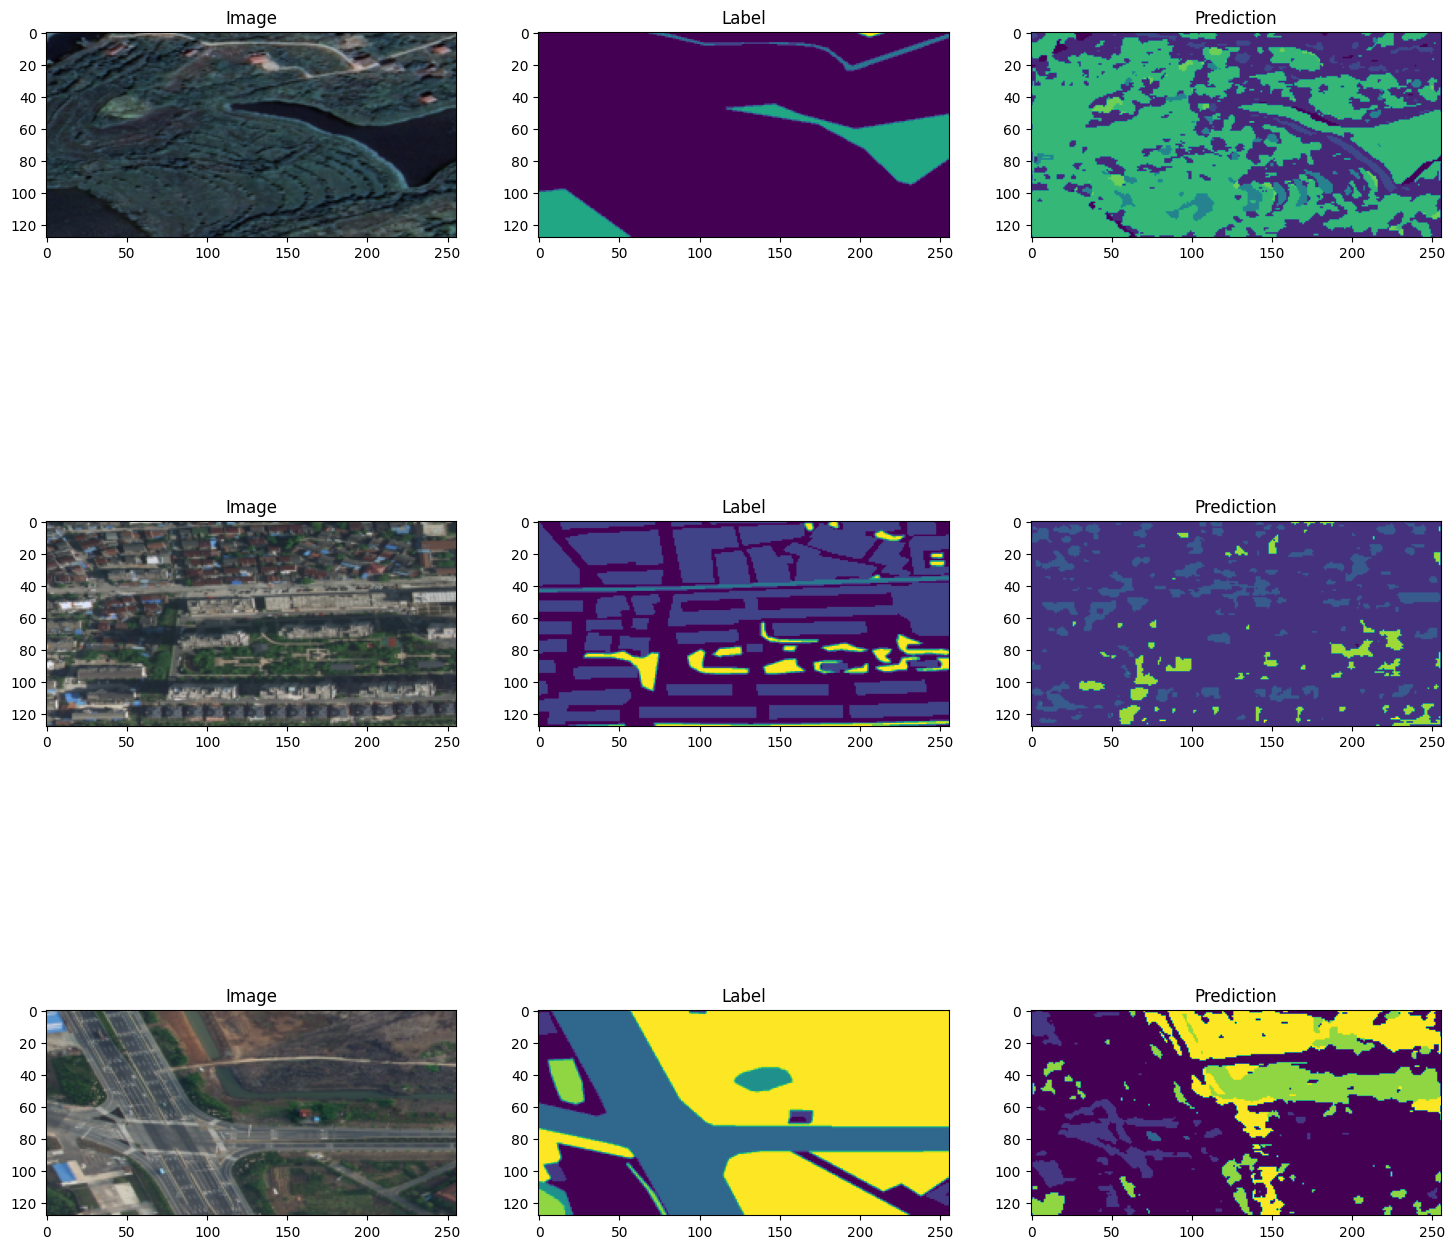

In [13]:
# Plot results

model.eval()

im_transforms = T.Compose([
    T.Resize((128, 256)),
    T.ToTensor(),
])

mask_transforms = T.Compose([
    T.Resize((128, 256)),
])

im1 = Image.open('/kaggle/input/loveda-grouped/LoveDA_grouped/Val/Val/images_png/2540.png')
im2 = Image.open('/kaggle/input/loveda-grouped/LoveDA_grouped/Val/Val/images_png/4132.png')
im3 = Image.open('/kaggle/input/loveda-grouped/LoveDA_grouped/Val/Val/images_png/4066.png')

mask1 = Image.open('/kaggle/input/loveda-grouped/LoveDA_grouped/Val/Val/masks_png/2540.png')
mask2 = Image.open('/kaggle/input/loveda-grouped/LoveDA_grouped/Val/Val/masks_png/4132.png')
mask3 = Image.open('/kaggle/input/loveda-grouped/LoveDA_grouped/Val/Val/masks_png/4066.png')

im1 = im_transforms(im1)
im2 = im_transforms(im2)
im3 = im_transforms(im3)

mask1 = mask_transforms(mask1)
mask2 = mask_transforms(mask2)
mask3 = mask_transforms(mask3)

if torch.cuda.is_available():
    im1 = im1.cuda(non_blocking=True)
    #mask1 = mask1.cuda(non_blocking=True)
    im2 = im2.cuda(non_blocking=True)
    #mask2 = mask2.cuda(non_blocking=True)
    im3 = im3.cuda(non_blocking=True)
    #mask3 = mask3.cuda(non_blocking=True)
    
if opt.name_net == 'deeplab': 
    pred1 = model(im1[None,:,:,:])['out']
    pred2 = model(im2[None,:,:,:])['out']
    pred3 = model(im3[None,:,:,:])['out']
else:
    pred1 = model(im1[None,:,:,:])
    pred2 = model(im2[None,:,:,:])
    pred3 = model(im3[None,:,:,:])
    
pred1 = torch.squeeze(pred1)
pred1 = pred1.argmax(0).squeeze()
pred1 = pred1.cpu().detach().numpy()
pred2 = torch.squeeze(pred2)
pred2 = pred2.argmax(0).squeeze()
pred2 = pred2.cpu().detach().numpy()
pred3 = torch.squeeze(pred3)
pred3 = pred3.argmax(0).squeeze()
pred3 = pred3.cpu().detach().numpy()

fig , ax =  plt.subplots(3, 3, figsize=(18, 18))
ax[0][0].set_title('Image')
ax[0][1].set_title('Label')
ax[0][2].set_title('Prediction')
ax[1][0].set_title('Image')
ax[1][1].set_title('Label')
ax[1][2].set_title('Prediction')
ax[2][0].set_title('Image')
ax[2][1].set_title('Label')
ax[2][2].set_title('Prediction')
ax[0][0].imshow(np.squeeze(np.transpose(im1.squeeze().cpu(),(1,2,0))))
ax[0][1].imshow(mask1)
ax[0][2].imshow(pred1.squeeze(), vmin = 0, vmax = 9)
ax[1][0].imshow(np.squeeze(np.transpose(im2.squeeze().cpu(),(1,2,0))))
ax[1][1].imshow(mask2)
ax[1][2].imshow(pred2.squeeze())
ax[2][0].imshow(np.squeeze(np.transpose(im3.squeeze().cpu(),(1,2,0))))
ax[2][1].imshow(mask3)
ax[2][2].imshow(pred3.squeeze())


